# *<font color='green'>Introduction</font>*

# **<font color='blue'>Imports</font>**

In [1]:
# Data Analysis + Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Selenium
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.metrics.pairwise import cosine_similarity

# **<font color='blue'>Setup | Data-Reading </font>**

In [2]:
file_path = 'amazon_updated.csv'
amazon = pd.read_csv(file_path)

# By default, the program only prints 4 values, and fills the rest with '...'
pd.set_option('display.max_columns', None)

# By default, there is a width limit set, so items over that limit would be printed in a new line.
pd.set_option('display.width', 1000)

# **<font color='blue'>Initial Report Generation </font>**

In [3]:
print("Info")
amazon.info()

# Total number of entries
total_entries = len(amazon)

# Duplicate entries
duplicate_rows = amazon[amazon.duplicated()]  # Boolean function, selecting True iff that specific row in df is duplicated.
num_duplicate_rows = len(duplicate_rows)

# Missing Entries
# axis=1 represents a row-wise operation. If any value is missing in a row, that row is flagged.
missing_values = amazon[amazon.isnull().any(axis=1)]
num_missing_rows = len(missing_values)

# Calculate percentages
percentage_duplicate = (num_duplicate_rows / total_entries) * 100
percentage_missing = (num_missing_rows / total_entries) * 100

# Faulty data counts:
rounded_duplicate_percentage = round(percentage_duplicate, 2)
rounded_missing_percentage = round(percentage_missing, 2)
print("Duplicate Rows: " + str(num_duplicate_rows) + " (" + str(rounded_duplicate_percentage) + "%)")
print("Rows with Missing Values: " + str(num_missing_rows) + " (" + str(rounded_missing_percentage) + "%)")

# Used for outputting detailed reports of what column value is missing
for column in amazon.columns:
    # Check for missing values in the current column
    missing_count = amazon[column].isnull().sum()

    # Print the count of missing values for each column if it's greater than 0
    if missing_count > 0:
        print("The count of missing values in '" + str(column) + "' is: " + str(missing_count))

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
 16  h

# **<font color='blue'>Data Cleaning </font>**

In [4]:
amazon['discounted_price'] = amazon['discounted_price'].replace('[₹,]', '', regex=True).astype(float)

amazon['actual_price'] = amazon['actual_price'].replace('[₹,]', '', regex=True).astype(float)

amazon['discount_percentage'] = amazon['discount_percentage'].replace('%', '', regex=True).astype(float)

amazon = amazon[amazon['rating'] != '|']  # Removing rows with invalid ratings
amazon['rating'] = amazon['rating'].replace(',', '.', regex=True).astype(float)

amazon['rating_count'] = amazon['rating_count'].replace(',', '', regex=True).astype(float)

# **<font color='blue'>Filling Missing Values </font>**

In [5]:
amazon["rating"].fillna(amazon['rating'].mean(), inplace = True)
amazon["rating_count"] = amazon["rating_count"].fillna(amazon["rating_count"].mean())

# **<font color='green'>Visualisation</font>**

### *<font color='red'>Graph 1</font>*

**The relationship between ratings and the the actual prices.**

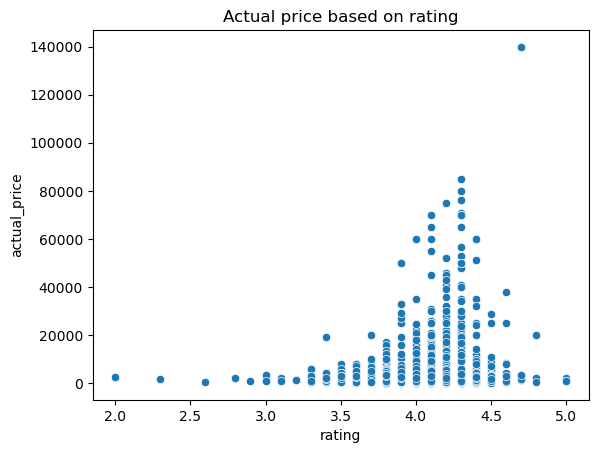

In [6]:
sns.scatterplot(data=amazon, y="actual_price", x="rating")
plt.title("Actual price based on rating")
plt.show()

### *<font color='red'>Graph 2</font>*

**The relationship between ratings and the the discounted prices.**

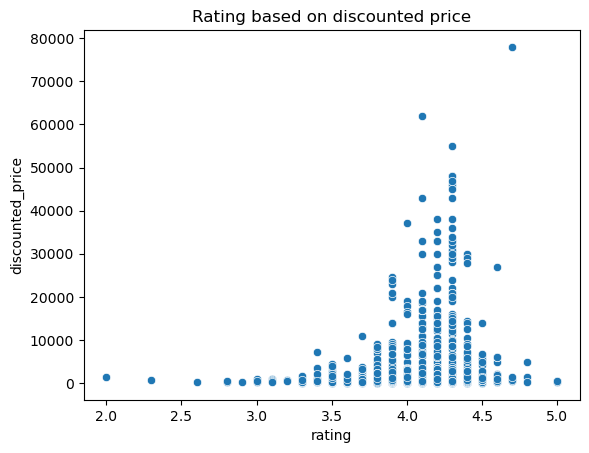

In [7]:
sns.scatterplot(data=amazon, y="discounted_price", x="rating")
plt.title("Rating based on discounted price")
plt.show()

**From graphs 1 and 2 it becomes clear that ratings were not affected by the price**

### *<font color='red'>Graph 3</font>*

**Below is the plot showing the relationship between Mean Rating and Discount Percentage, per each 10% dicount.**

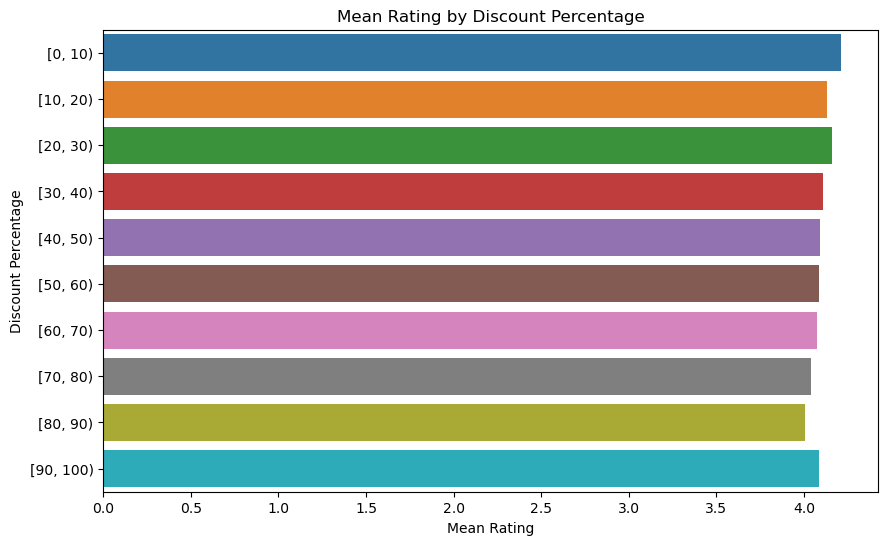

In [8]:
bins = np.arange(0, 101, 10) 

amazon["discount_bin"] = pd.cut(amazon["discount_percentage"], bins, right=False)

grouped_data = amazon.groupby("discount_bin")["rating"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x="rating", y="discount_bin", orient="h")
plt.xlabel("Mean Rating")
plt.ylabel("Discount Percentage")
plt.title("Mean Rating by Discount Percentage")
plt.show()

### *<font color='red'>Graph 4</font>*

**Histogram showing the frequency of values in Actual Price. As a result, we can observe that the most frequent actual prices are less than 20000.**

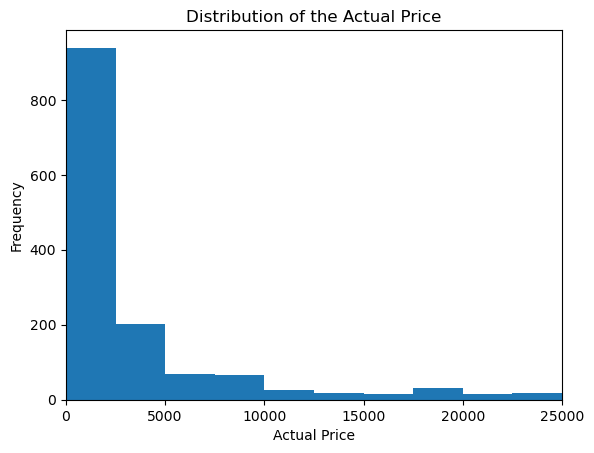

In [9]:
# Assuming amazon['actual_price'] contains your data.
data_min = 0  # or set manually to 0 if it fits your data range
data_max = 25000  # or set manually if you know the max value

bins = np.arange(data_min, data_max + 2500, 2500)  # creates bins from min to max with 2000 increments

plt.hist(amazon['actual_price'], bins=bins)
plt.xlim(0, 25000)
plt.title('Distribution of the Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Frequency')
plt.show()

### *<font color='red'>Graph 5</font>*

**The graph shows the frequency of Product Ratings. The mst frequent rating (more than 400) is in the range [4.0, 4.5].**

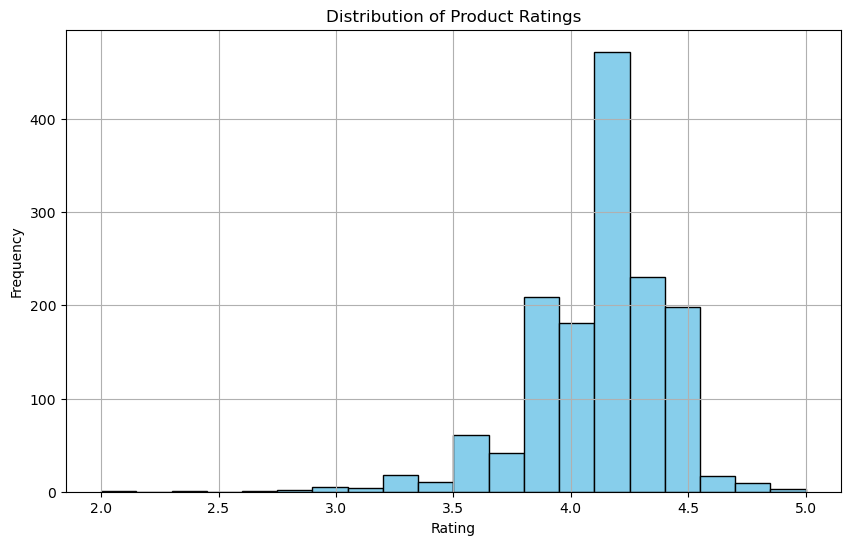

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(amazon['rating'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
# Product rating in range of 4.0-4.5

group_by_item = amazon.groupby("product_name")["rating"].mean()

products_in_range = group_by_item[(group_by_item >= 4.0) & (group_by_item <= 4.5)]

product_names_in_range = pd.DataFrame(products_in_range.index.tolist())

print(product_names_in_range)

                                                     0
0    !!1000 Watt/2000-Watt Room Heater!! Fan Heater...
1    10WeRun Id-116 Bluetooth Smartwatch Wireless F...
2    3M Post-it Sticky Note Cube, 200 Sheets (4 Col...
3    7SEVEN® Compatible Lg Smart Tv Remote Suitable...
4    7SEVEN® Compatible for Tata Sky Remote Origina...
..                                                 ...
963  realme Buds Classic Wired in Ear Earphones wit...
964  realme Buds Wireless in Ear Bluetooth Earphone...
965  realme narzo 50 (Speed Blue, 4GB RAM+64GB Stor...
966  realme narzo 50i (Mint Green, 2GB RAM+32GB Sto...
967  rts [2 Pack] Mini USB C Type C Adapter Plug, T...

[968 rows x 1 columns]


### *<font color='red'>Graph 6</font>*

**This code generates a scatter plot showing the relationship between product ratings and the number of reviews on Amazon, with dark red points.**

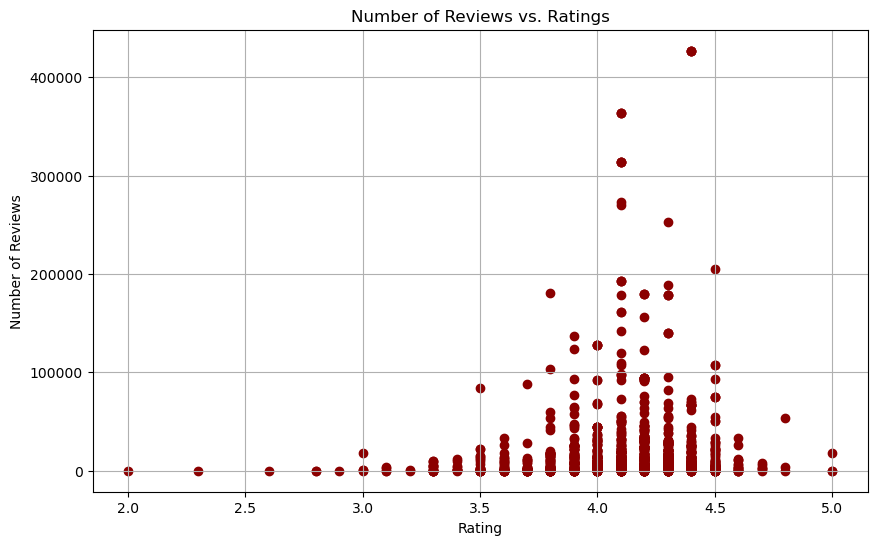

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(amazon['rating'], amazon['rating_count'], color='darkred')
plt.title('Number of Reviews vs. Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

### *<font color='red'>Graph 7</font>*

**This code calculates and compares the discounted prices of products on Amazon, creating a scatter plot to visualize the relationship between the calculated and provided discounted prices.**

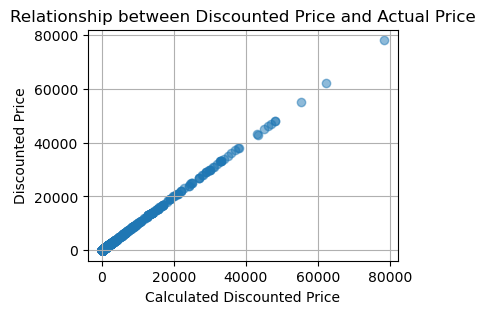

In [13]:
# Calculate discounted price based on actual price and discount percentage
amazon['calculated_discounted_price'] = amazon['actual_price'] * (1 - amazon['discount_percentage'] / 100)

# Create a scatter plot
plt.figure(figsize=(4, 3))
plt.scatter(amazon['calculated_discounted_price'], amazon['discounted_price'], alpha=0.5)
plt.title('Relationship between Discounted Price and Actual Price')
plt.xlabel('Calculated Discounted Price')
plt.ylabel('Discounted Price')
plt.grid(True)
plt.show()


### *<font color='red'>Graph 8</font>*

**This code calculates the average discount percentage for different product categories on Amazon and optionally visualizes the results using a bar plot.**

truncated_categories
Car&Motorb...    42.000000
Computers&...    54.024283
Electronic...    50.828897
Health&Per...    53.000000
Home&Kitch...    40.174497
HomeImprov...    57.500000
MusicalIns...    46.000000
OfficeProd...    12.354839
Toys&Games...     0.000000
Name: discount_percentage, dtype: float64


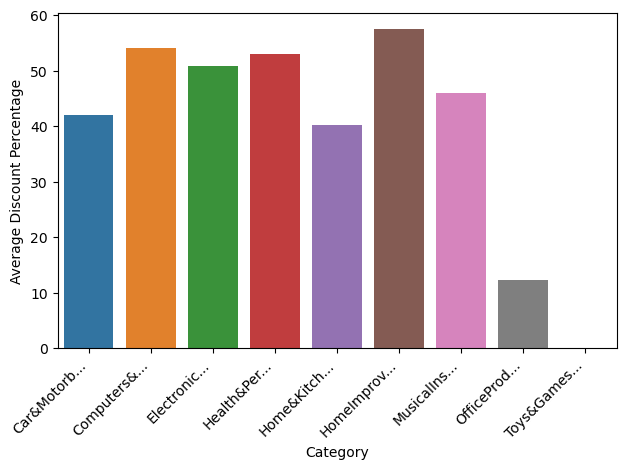

<Figure size 1000x600 with 0 Axes>

In [14]:
# How does the average discount percentage vary across categories

# Calculate average discount percentage per category
amazon['truncated_categories'] = [category[:10] + '...' if len(category) > 10 else category for category in amazon['category']]
avg_discount_per_category = amazon.groupby('truncated_categories')['discount_percentage'].mean()
# Display results
print(avg_discount_per_category)

# Optional: Visualization
sns.barplot(x=avg_discount_per_category.index, y=avg_discount_per_category.values)
plt.xlabel("Category")
plt.ylabel("Average Discount Percentage")
plt.xticks(rotation=45, ha='right')  # Rotate the category labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.figure(figsize=(10, 6))
plt.show()

### *<font color='red'>Graph 9</font>*

**This code calculates the count of products by main category**

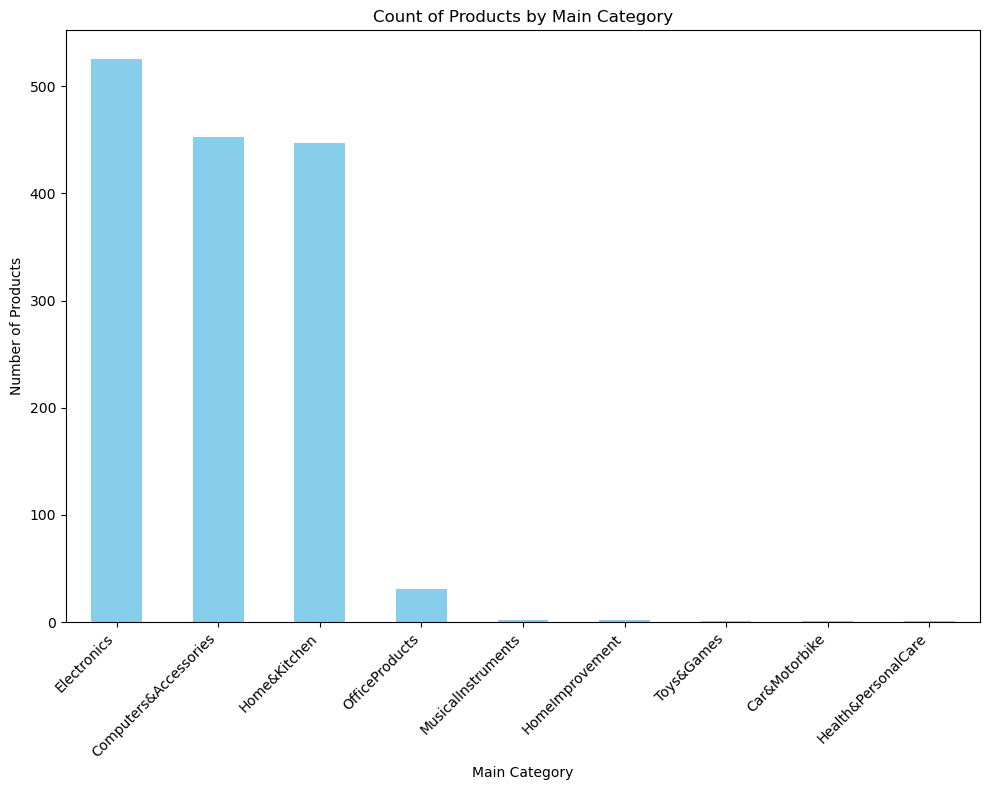

In [15]:
amazon['main_category'] = amazon['category'].apply(lambda x: x.split('|')[0] if '|' in x else x)
category_counts = amazon['main_category'].value_counts()

# Create bar chart for product counts by main category
plt.figure(figsize=(10, 8))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Products by Main Category')
plt.xlabel('Main Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### *<font color='red'>Graph 10</font>*

**This code provides the word cloud for the product names in the database listing**

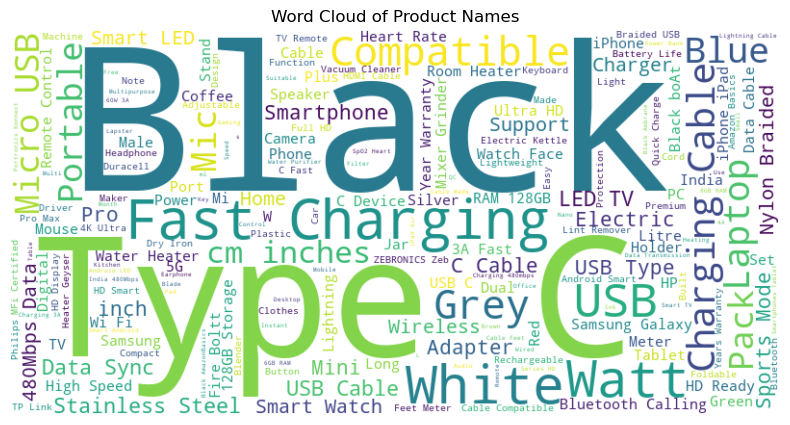

In [16]:
product_names_text = ' '.join(amazon['product_name'])

# Create a word cloud image
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(product_names_text)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not show axes to keep it clean
plt.title('Word Cloud of Product Names')
plt.show()

### *<font color='red'>Graph 11</font>*

**This code provides the discounted mean price listing for the most frequent categories**

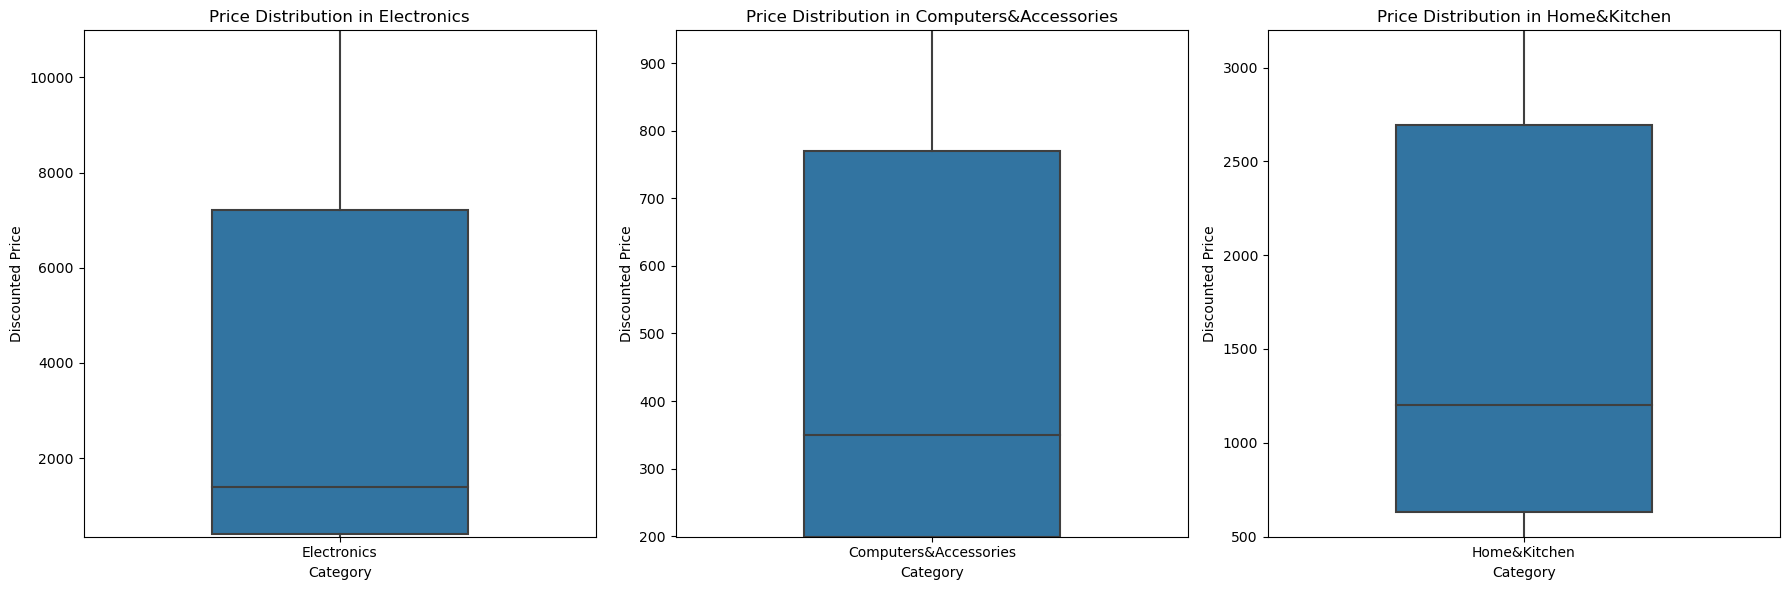

In [17]:
# Determine the most frequent categories
category_counts = amazon['main_category'].value_counts().nlargest(3)  # Top 3 categories
frequent_categories = category_counts.index.tolist()

# Filter data for these categories
filtered_data = amazon[amazon['main_category'].isin(frequent_categories)]

# Setup the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Iterate over categories and create a plot for each
for ax, category in zip(axes, frequent_categories):
    # Filter the category data
    category_data = filtered_data[filtered_data['main_category'] == category]
    
    # Calculate the 20th and 80th percentiles
    lower_bound = category_data['discounted_price'].quantile(0.20)
    upper_bound = category_data['discounted_price'].quantile(0.80)
    
    # Create the boxplot
    sns.boxplot(x='main_category', y='discounted_price', data=category_data, ax=ax, width = 0.5)
    ax.set_title(f'Price Distribution in {category}')
    ax.set_ylim(lower_bound, upper_bound)
    ax.set_xlabel('Category')
    ax.set_ylabel('Discounted Price')

plt.tight_layout()
plt.show()

### *<font color='red'>Graph 12</font>*

**The code selects numeric columns from the Amazon dataset, computes their correlation matrix, and visualizes it as a heatmap.**

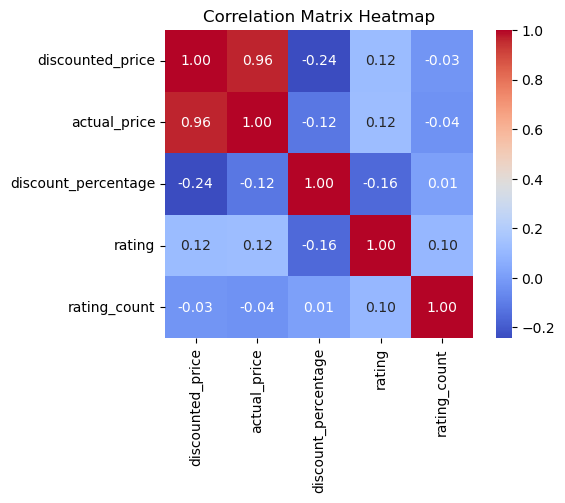

In [18]:
# Select only the numeric columns for correlation analysis
numeric_columns = amazon.select_dtypes(include=['int64', 'float64'])
numeric_columns = numeric_columns.drop(columns='calculated_discounted_price', errors='ignore')
# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Hypothesis 1: Discounted Price, Rating, and Rating count are closely related.

### **Additional Research**

In [19]:
# Fetch Top Products (>= 75th percentile in rating and rating_count)

# Calculate the 75th percentile for 'rating' and 'rating_count' within each category
rating_75th_percentile = amazon.groupby('category')['rating'].transform(lambda x: x.quantile(0.75))
rating_count_75th_percentile = amazon.groupby('category')['rating_count'].transform(lambda x: x.quantile(0.75))

# Create a boolean mask where both 'rating' and 'rating_count' are at or above the 75th percentile
mask = (amazon['rating'] >= rating_75th_percentile) & (amazon['rating_count'] >= rating_count_75th_percentile)

# Apply the mask to the DataFrame to get the filtered DataFrame
top_products = amazon[mask]

print(len(top_products))

# Hypothesis 2: Top products have more images
valid_images_percentage_top = (top_products['has_image'].sum() / len(top_products)) * 100
print(f"Percentage of top products with images': {valid_images_percentage_top:.2f}%")

265
Percentage of top products with images': 55.47%


In [20]:
# Group data by category and calculate average rating
average_ratings = amazon.groupby("category")["rating"].mean().reset_index()

# Sort by average rating in descending order
average_ratings = average_ratings.sort_values(by="rating", ascending=False)

# Print the top 5 categories
print("Top 5 categories with highest average ratings:")
for i in range(5):
    category = average_ratings.iloc[i]["category"]
    average_rating = average_ratings.iloc[i]["rating"]
    print(f"{i+1}. {category}: {average_rating:.2f}")
    
average_ratings

Top 5 categories with highest average ratings:
1. Computers&Accessories|Tablets: 4.60
2. Computers&Accessories|NetworkingDevices|NetworkAdapters|PowerLANAdapters: 4.50
3. Electronics|Cameras&Photography|Accessories|Film: 4.50
4. Electronics|HomeAudio|MediaStreamingDevices|StreamingClients: 4.50
5. OfficeProducts|OfficeElectronics|Calculators|Basic: 4.50


,category,rating
57,Computers&Accessories|Tablets,4.6
48,Computers&Accessories|NetworkingDevices|Networ...,4.5
62,Electronics|Cameras&Photography|Accessories|Film,4.5
81,Electronics|HomeAudio|MediaStreamingDevices|St...,4.5
196,OfficeProducts|OfficeElectronics|Calculators|B...,4.5
...,...,...
3,Computers&Accessories|Accessories&Peripherals|...,3.6
88,"Electronics|HomeTheater,TV&Video|Accessories|3...",3.5
2,Computers&Accessories|Accessories&Peripherals|...,3.5
14,Computers&Accessories|Accessories&Peripherals|...,3.4


In [21]:
data = amazon.copy()
# Function to clean and preprocess text
def clean_text(text):
    # Lowercasing, removing punctuation, and non-alphabetic characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lower case
    return text
# Preprocess and clean the text data
data['clean_about_product'] = data['about_product'].apply(clean_text)
data['clean_review_content'] = data['review_content'].apply(clean_text)
# Update the TF-IDF vectorizer to include bi-grams and tri-grams
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,3))

# Fit and transform the 'clean_about_product' and 'clean_review_content' text to TF-IDF vectors
tfidf_about_product = tfidf_vectorizer.fit_transform(data['clean_about_product'])
tfidf_review_content = tfidf_vectorizer.fit_transform(data['clean_review_content'])
combined_features = (tfidf_about_product + tfidf_review_content) / 2


In [22]:
def recommend_products(user_input, top_n=5, tau=0.25):
    # Clean user input and split into keywords
    cleaned_input = clean_text(user_input)
    keywords = set(cleaned_input.split())
    
    # Filter data for entries containing keywords in 'product_name' or 'about_product'
    mask = data['clean_about_product'].apply(lambda x: any(kw in x for kw in keywords)) | \
           data['product_name'].apply(lambda x: any(kw in clean_text(x) for kw in keywords))
    filtered_data = data[mask]
    
    if filtered_data.empty:
        return pd.DataFrame()
    
    # Apply TF-IDF vectorization to the filtered data
    filtered_tfidf = tfidf_vectorizer.transform(filtered_data['clean_about_product'])
    
    # Calculate cosine similarity between user input and filtered products
    input_vector = tfidf_vectorizer.transform([cleaned_input])
    similarity_scores = cosine_similarity(input_vector, filtered_tfidf).flatten()
    
    # Filter products based on the similarity threshold tau
    valid_scores = [(index, score) for index, score in enumerate(similarity_scores) if score > tau]
    valid_scores.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity score in descending order
    
    # Collect indices ensuring unique first 20 characters of product names
    unique_names = set()
    top_indices = []
    for idx, _ in valid_scores:
        if len(top_indices) >= top_n:
            break
        prod_name_prefix = filtered_data.iloc[idx]['product_name'][:20]
        if prod_name_prefix not in unique_names:
            unique_names.add(prod_name_prefix)
            top_indices.append(idx)
    
    # Adjust the number of recommendations to ensure at least min_n or as many as top_n
    min_n = max(5, len(top_indices))  # Ensure at least 5 recommendations if available
    recommended_products = filtered_data.iloc[top_indices[:min_n]]
    
    return recommended_products

In [23]:
def interactive_recommendation_session():
    print("Hello! Describe the product you're looking for:")
    user_input = input()
    
    # Check if the input is a termination command
    if user_input.strip().lower() in ["", "none", "stop"]:
        print("Session terminated.")
        return False
    
    recommendations = recommend_products(user_input)
    if recommendations.empty:
        print("No products found above the similarity threshold. Try using different keywords.")
        return True
    
    print("\nHere are some products that might interest you:")
    print(recommendations[['product_name', 'discounted_price', 'rating']])
    
    # Collect feedback
    print("\nDo any of these meet your needs? (Enter the number of the product or 'none' if none are suitable)")
    feedback = input()
    
    if feedback.lower() == 'none':
        print("Let's try refining your search. Please provide more details or different criteria:")
        new_input = input()
        new_recommendations = recommend_products(new_input)
        if new_recommendations.empty:
            print("No suitable products found. Try searching for something else.")
            return True
        else:
            print(new_recommendations[['product_name', 'discounted_price', 'rating']])
            return True
    else:
        try:
            selected_index = int(feedback) - 1  # Adjusting for zero-based index
            selected_product = recommendations.iloc[selected_index]
            print(f"\nYou selected: {selected_product['product_name']}, priced at {selected_product['discounted_price']}.")
            print(f"Check it out on Amazon: {selected_product['product_link']}")
            return True
        except:
            print("Invalid selection. Please start over.")
            return True

# Main loop for the interactive session
while True:
    if not interactive_recommendation_session():
        break


Hello! Describe the product you're looking for:
i am looking for headphones

Here are some products that might interest you:
                                           product_name  discounted_price  rating
1015  boAt BassHeads 900 On-Ear Wired Headphones wit...             849.0     4.2

Do any of these meet your needs? (Enter the number of the product or 'none' if none are suitable)
1

You selected: boAt BassHeads 900 On-Ear Wired Headphones with Mic (White), priced at 849.0.
Check it out on Amazon: https://www.amazon.in/Heads-900-Wired-Headphones-White/dp/B078W65FJ7/ref=sr_1_493?qid=1672903019&s=computers&sr=1-493
Hello! Describe the product you're looking for:
i want a charging cable

Here are some products that might interest you:
                                          product_name  discounted_price  rating
58   Wecool Unbreakable 3 in 1 Charging Cable with ...             348.0     4.2
45   Wecool Nylon Braided Multifunction Fast Chargi...             333.0     3.3
557  LAPSTE